In [2]:
pip install folium

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 93 kB 378 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import folium
import warnings

## Цель проекта: 
    
#### Исследование рынка общественного питания в городе Москва с целью определения потенциальных возможностей для открытия заведения нового типа.     
    

### Оглавление:

1. [Загрузка и подготовка данных к анализу](#step1) 
2. [Соотношение видов объектов общественного питания по количеству](#step2)
3. [Соотношение сетевых и несетевых заведений](#step3)
4. [Для какого вида объекта общественного питания характерно сетевое распространение](#step4)
5. [Характерные особенности сетевых заведений](#step5)
6. [Среднее количество посадочных мест для каждого вида объекта общественного питания](#step6) 
7. [Топ-10 улиц по количеству объектов общественного питания](#step7) 
8. [Определение района для ТОП 10 улиц по количеству объектов общественного питания](#step8)
9. [Улицы с одним объектом общественного питания](#step9) 
10. [Определение района для улиц с одним  объектом общественного питания](#step10) 
11. [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#step11) 
12. [Общий вывод по проекту ](#step12)

### Загрузка и подготовка данных к анализу<a id="step1"></a>  

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [6]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Проверим данные на наличие дубликатов и пропущенных значений

In [7]:
data.duplicated(subset=['address', 'number', 'object_type', 'chain', 'object_name']).sum()

82

In [14]:
# убедимся что данные полностью совпадают и удалим дубликаты

In [13]:
duplicaterows = data[data.duplicated(['address', 'number', 'object_type', 'chain', 'object_name'])]
duplicaterows.head(15)

data = data.drop_duplicates(subset=['address', 'number', 'object_type', 'chain', 'object_name'], keep='first')

In [16]:
data.isnull().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Приведем данные к нижнему регистру

In [17]:
data['object_name'] = data['object_name'].str.lower()
data['address'] = data['address'].str.lower()

Вывод:

Данные проверены на пропущенные значения и тип. Так же для дальнейшего анализа датасет был проверен на дубликаты и необходимые столбцы были приведены к одному регистру. Было решено не удалять дублирующиеся значения, так как по одному адресу располагаются разные заведения, так же встречаюстя варианты одного заведения, но с разной посадкой. 

### Соотношение видов объектов общественного питания по количеству<a id="step2"></a>  

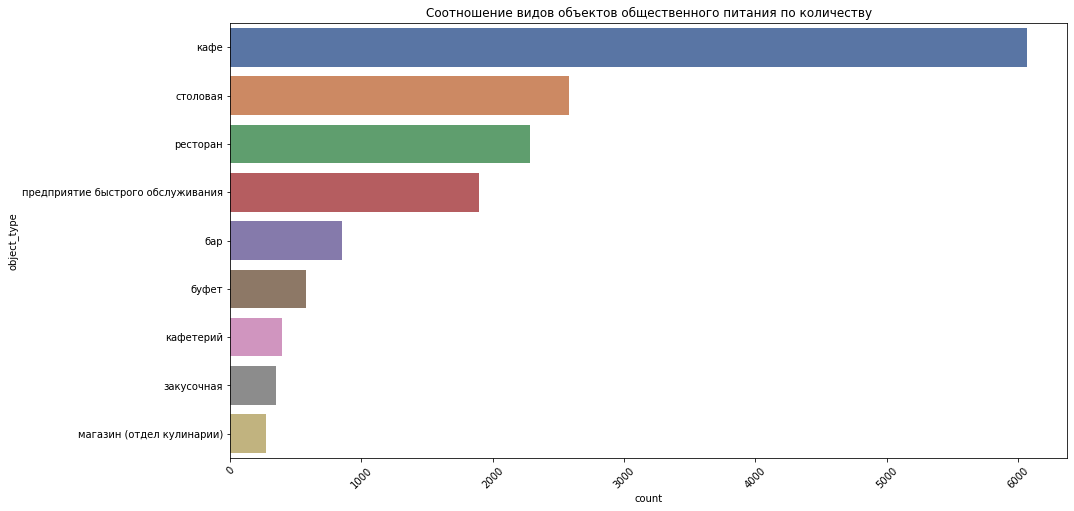

In [18]:
plt.figure(figsize=(15, 8))
plt.title('Соотношение видов объектов общественного питания по количеству')
sns.countplot(y='object_type', data=data, palette='deep', order=data['object_type'].value_counts().index)
plt.xticks(rotation=45);
plt.savefig('Соотношение видов объектов общественного питания по количеству')

Вывод: 

На графике хорошо видно, что самым популярным заведение является кафе с 6000 заведений. По количеству оно идет с большим отрывов по сравнению со всеми остальными, далее идет столовая(около 2500) и потом ресторан (2200-2300). Три самых популярных вида объекта общественного питания в то же время являются так же  представляют три разных ценовых сегмента. 

### Соотношение сетевых и несетевых заведений <a id="step3"></a>  

In [19]:
data['chain'].value_counts()

нет    12320
да      2964
Name: chain, dtype: int64

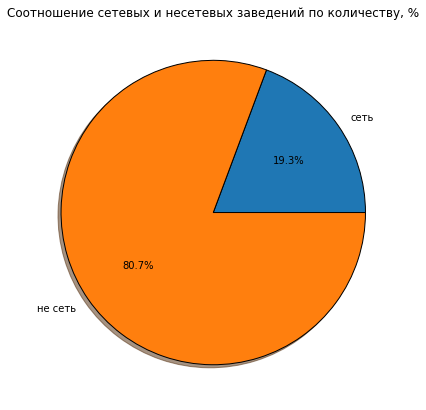

In [20]:
labels = ['сеть', 'не сеть']
values = [2968, 12398]

plt.figure(figsize=(10,7))
plt.title('Соотношение сетевых и несетевых заведений по количеству, %')
plt.pie(values, labels = labels, wedgeprops = {'edgecolor': 'black'}, shadow=True, autopct='%1.1f%%');
plt.savefig('Соотношение сетевых и несетевых заведений по количеству')

Вывод: 

Большая частть заведений не являются сетевыми, о чем можно судить по диаграмме. На долю сетевых заведений приходится всего 19,3% мест, в то время как несетевые заведения составляют 80,7%

### Для какого вида объекта общественного питания характерно сетевое распространение<a id="step4"></a> 

In [22]:
chain_type = px.histogram(data, x='object_type', 
                          color='chain', title='Характерное сетевое распространение для разных видов объектов'
                         ).update_xaxes(categoryorder ='total ascending')
chain_type.show()

Вывод: 

На графике хорошо видно, что больше всего сетевых заведений характерно для кафе, предприятий общественного питания и ресторанов. У предприятий общественного питания доля сетевых заведений составляет практически половину, у кафе и ресторанов чуть меньше 1/3. У всех остальных видов, сетевые заведения так же имеются, но имеют очень маленькую долю. 


### Характерные особенности сетевых заведений <a id="step5"></a> 

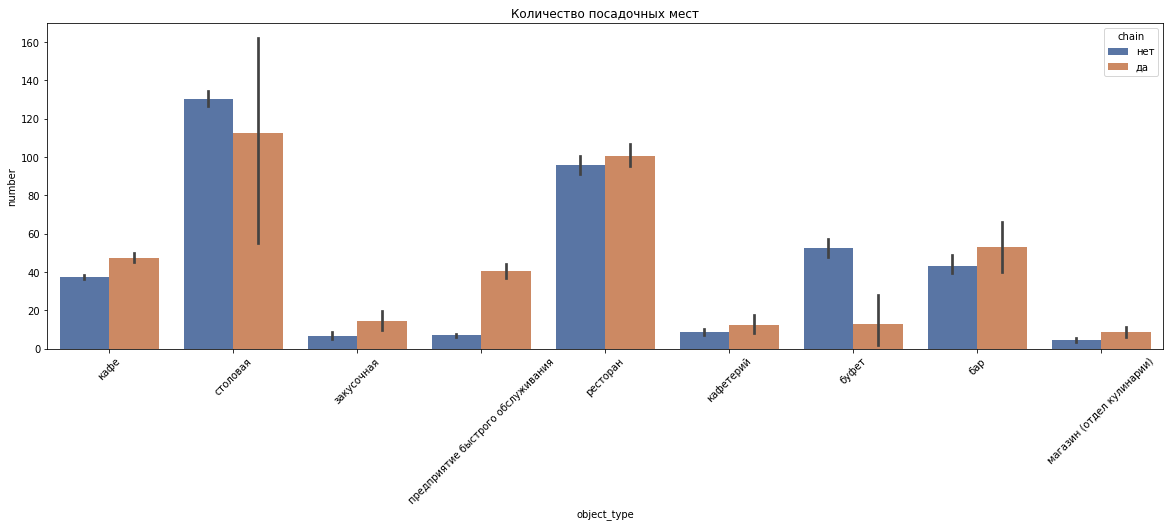

In [23]:
plt.figure(figsize=(20, 6))
chain_number = sns.barplot(data=data, x='object_type', y='number', palette='deep', hue='chain')
plt.title('Количество посадочных мест')
plt.xticks(rotation=45);
plt.savefig('Количество посадочных мест')

In [15]:
# найдем среднее количество посадочных мест в 15 самых крупных сетевых заведений

In [31]:
chain_seats = data.loc[data['chain'] == 'да']
chain_seats.pivot_table(index='object_name', values=['object_type', 'number'], 
                       aggfunc={'object_type': 'count', 'number':'mean'
                               }).sort_values(by='object_type', ascending=False).reset_index().head(15)

,object_name,number,object_type
0,шоколадница,57.184713,157
1,kfc,55.341935,155
2,макдоналдс,87.700000,150
3,бургер кинг,46.649635,137
4,теремок,25.606383,94
5,крошка картошка,21.855556,90
6,домино'с пицца,18.344444,90
7,милти,1.333333,72
8,суши wok,6.708333,72
9,папа джонс,22.039216,51


Вывод:
    
Нет определенной закономерности по количеству посадочных мест в сетевых заведениях. На графике, мы видим что у всех типов заведений, кроме столовых, и буфетов в сетевых заведениях в среднем больше посадочных мест и количество самих заведений больше. Так же мы видим что все сетевые заведения кроме Чайхоны, Якитории и Макдоналдса имеют небольшую посадку, в основном 50 и менее мест. ТОповые сети имеют в целом большое количество заведений и небольшую посадку (кроме Макдоналдса)

### Среднее количество посадочных мест для каждого вида объекта общественного питания<a id="step6"></a> 

In [32]:
data['number'].describe()

count    15284.000000
mean        59.784350
std         74.838657
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

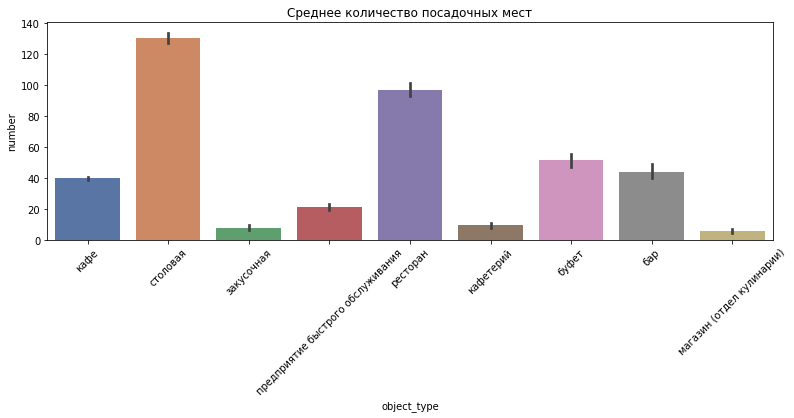

In [33]:
plt.figure(figsize=(13, 4))
med_number = sns.barplot(data=data, x='object_type', y='number', palette='deep')
plt.title('Cреднее количество посадочных мест')
plt.xticks(rotation=45);
plt.savefig('Cреднее количество посадочных мест')

Вывод:
В среднем, самое большое количество посадочных мест имеет столовые (около 130), далее идет ресторан (100) и после со значительным отрывом - буфет (~55)

Выделим в отдельный столбец информацию об улице из столбца address 

In [34]:
# удалим лишние пробелы из адреса

In [35]:
data['address'] = data['address'].str.lstrip()

In [36]:
# отдельно выделим улицу

In [37]:
def fix_address(address):
    if "город москва" in address.lower():
        return address.split(',')[1]
    else:
        return address.split(',')[0]

data['fixed_street'] = data['address'].apply(fix_address)
data.head()

,id,object_name,chain,object_type,address,number,fixed_street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


In [38]:
# удалим лишние пробелы из адреса

In [39]:
data['fixed_street'] = data['fixed_street'].str.lstrip()

In [40]:
exceptions = pd.Series(["город зеленоград","город москва","город московский","поселение михайлово-ярцевское", "город троицк","поселение сосенское","поселение марушкинское", "поселение михайлово-ярцевское","поселение \"мосрентген\"","поселение марушкинское"])
# exceptions

In [41]:
data_filtered = data.query('fixed_street not in @exceptions')
# data_filtered

Я приняла решение убрать эти города и поселения, так как они не находятся непосредственно в Москве, а контекст задания - кафе в Москве. 

### Топ-10 улиц по количеству объектов общественного питания<a id="step7">

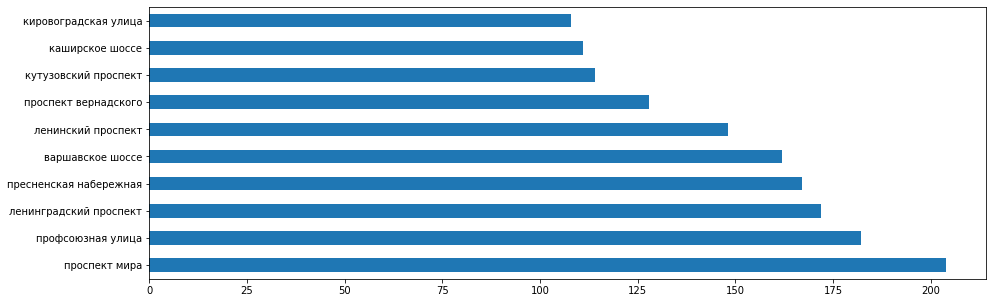

In [42]:
top10_streets = (data_filtered['fixed_street'].value_counts().sort_values(ascending=False).head(10))

top10_streets.plot(kind='barh', figsize=(15,5));

plt.savefig(' Топ-10 улиц по количеству объектов общественного питания')

### Определение района для ТОП 10 улиц по количеству объектов общественного питания<a id="step8">

In [43]:
# найдем районы для топ 10 улиц

In [44]:
top_10_street_filtered = pd.Series(['проспект мира', 'профсоюзная улица', 'ленинградский проспект',
                                    'пресненская набережная', 'варшавское шоссе', 'ленинский проспект',
                                    'проспект вернадского', 'кутузовский проспект', 'каширское шоссе', 'кировоградская улица'])

In [45]:
data_top10_filtered = data.query('fixed_street  in @top_10_street_filtered')
data_top10_filtered.head()

,id,object_name,chain,object_type,address,number,fixed_street
151,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе
152,23618,кафе «subway»,да,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,варшавское шоссе
153,155852,кафе «ламаджо»,нет,кафе,"город москва, варшавское шоссе, дом 29",30,варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,варшавское шоссе
155,120658,выпечка,нет,кафетерий,"город москва, варшавское шоссе, дом 100",2,варшавское шоссе


In [46]:
# обозначим адрес геокодера и токин, через которые будем собирать информацию. 

In [47]:
API_URL = 'https://geocode-maps.yandex.ru/1.x'

token = '41e9c8c8-4249-4a1c-b240-95e47e7243ac'

In [48]:
# напишем функцию, которая собирает коррдинаты по топ10 улицам

In [49]:
def get_coordinates_by_address(street):
    address = street
    params = {
        'geocode': address,
        'format': 'json',
        'apikey': token
    }

    for n in range(4):
        print(f'Адрес {street}. Попытка номер {n+1}')
        
        try:
            r = requests.get(API_URL, params=params)
            return r.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        except:
            print('Запрос не удался, пауза {} секунд(ы)'.format(2**(n+1)))
            time.sleep(2**(n+1))

In [50]:
data_top10_filtered["address_coordinates"] = data_top10_filtered["address"].apply(get_coordinates_by_address)

Адрес город москва, варшавское шоссе, дом 2. Попытка номер 1
Адрес город москва, варшавское шоссе, дом 7, корпус 1. Попытка номер 1
Адрес город москва, варшавское шоссе, дом 29. Попытка номер 1
Адрес город москва, варшавское шоссе, дом 72, корпус 2. Попытка номер 1
Адрес город москва, варшавское шоссе, дом 100. Попытка номер 1
Адрес город москва, варшавское шоссе, дом 143а. Попытка номер 1
Адрес город москва, проспект вернадского, дом 9/10. Попытка номер 1
Адрес город москва, проспект вернадского, дом 11/19. Попытка номер 1
Адрес город москва, проспект вернадского, дом 11/19. Попытка номер 1
Адрес город москва, проспект вернадского, дом 11/19. Попытка номер 1
Адрес город москва, проспект вернадского, дом 11/19. Попытка номер 1
Адрес город москва, проспект вернадского, дом 13. Попытка номер 1
Адрес город москва, проспект вернадского, дом 37. Попытка номер 1
Адрес город москва, проспект вернадского, дом 86, строение 1. Попытка номер 1
Адрес город москва, проспект вернадского, дом 93. Поп

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
# data_top10_filtered.head()

In [52]:
# напишем функцию которая соберет полный адрес по полученным ранее координатам и добавлять в отфильтрованный датафрейм
# напишем цикл, который не будет прерывать работу в случае ошибки  

In [53]:
def get_full_address_by(coordinates):
    if coordinates is not None:
        params = {
            'geocode': ','.join(coordinates.split(' ')),
            'format': 'json',
            'apikey': token
        }
        for n in range(4):
            print(f'Координаты {coordinates}. Попытка номер {n+1}')

            try:
                r = requests.get(API_URL, params=params)
                return r.json()
            except:
                print('Запрос не удался, пауза {} секунд(ы)'.format(2**(n+1)))
                time.sleep(2**(n+1))

In [54]:
data_top10_filtered["address_from_api"] = data_top10_filtered["address_coordinates"].apply(get_full_address_by)

Координаты 37.619683 55.699943. Попытка номер 1
Координаты 37.622405 55.700877. Попытка номер 1
Координаты 37.622432 55.693226. Попытка номер 1
Координаты 37.618767 55.656839. Попытка номер 1
Координаты 37.618812 55.646228. Попытка номер 1
Координаты 37.599148 55.583953. Попытка номер 1
Координаты 37.532511 55.690755. Попытка номер 1
Координаты 37.528882 55.688741. Попытка номер 1
Координаты 37.528882 55.688741. Попытка номер 1
Координаты 37.528882 55.688741. Попытка номер 1
Координаты 37.528882 55.688741. Попытка номер 1
Координаты 37.527669 55.687655. Попытка номер 1
Координаты 37.511751 55.678397. Попытка номер 1
Координаты 37.474534 55.66049. Попытка номер 1
Координаты 37.495132 55.667127. Попытка номер 1
Координаты 37.491377 55.667152. Попытка номер 1
Координаты 37.491377 55.667152. Попытка номер 1
Координаты 37.492662 55.663365. Попытка номер 1
Координаты 37.482026 55.655478. Попытка номер 1
Координаты 37.452103 55.723719. Попытка номер 1
Координаты 37.629071 55.671168. Попытка н

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
# data_top10_filtered.head()

In [56]:
# напишем функцию которая будет определять район по полученным полным данным с api

In [57]:
def extract_district_from_address(address):
    if address is not None:
        try:
            return address['response']['GeoObjectCollection']['featureMember'][2]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][5]['name']
        except IndexError:
            pass
        
data_top10_filtered["district"] = data_top10_filtered["address_from_api"].apply(extract_district_from_address)
data_top10_filtered.head()
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,object_name,chain,object_type,address,number,fixed_street,address_coordinates,address_from_api,district
151,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,37.619683 55.699943,{'response': {'GeoObjectCollection': {'metaDat...,Донской район
152,23618,кафе «subway»,да,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,варшавское шоссе,37.622405 55.700877,{'response': {'GeoObjectCollection': {'metaDat...,Донской район
153,155852,кафе «ламаджо»,нет,кафе,"город москва, варшавское шоссе, дом 29",30,варшавское шоссе,37.622432 55.693226,{'response': {'GeoObjectCollection': {'metaDat...,Донской район
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,варшавское шоссе,37.618767 55.656839,{'response': {'GeoObjectCollection': {'metaDat...,Нагорный район
155,120658,выпечка,нет,кафетерий,"город москва, варшавское шоссе, дом 100",2,варшавское шоссе,37.618812 55.646228,{'response': {'GeoObjectCollection': {'metaDat...,Нагорный район


In [58]:
# напишем функцию, котрая преобразует полученные ранеее координаты в нужный нам формат для дальнейшего нанесения их на карту. 

In [59]:
def switch_position(coorditate):
    if coorditate is not None:
        result = coorditate.split(' ')

        return ', '.join([result[1],result[0]])

data_top10_filtered['map_coordinates'] = data_top10_filtered['address_coordinates'].apply(switch_position)
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
# нанесем полученные данные на карту, для более понятного визуального восприятия 
# первыми координатами укажем центр Москвы, где центровки всей карты
# сгруппируем данные по районам, чтобы избежать большого количество маркеров на карте

In [61]:
district_for_top = pd.pivot_table(data_top10_filtered, index='district', values='map_coordinates', 
                    aggfunc= 'max').reset_index().head(30)

In [62]:
moscow_centre = [55.755814, 37.617635]
map_top10 = folium.Map(
    location=moscow_centre,
    zoom_start=10.45
)

for index, row in district_for_top.iterrows():
    if row['map_coordinates'] and row['district'] is not None:
        district_name = row['district'].encode('raw_unicode_escape').decode('utf8')
        folium.Marker(row['map_coordinates'].split(','), popup=district_name).add_to(map_top10)
map_top10

Вывод:

ТОП 10 улиц с самым большим количеством объектов общественного питания находятся за пределами третьего транспортного кольца. Самым популярным районом для общепита является Ломоносовский, там находятся две из десяти улиц. Далее идут два района которые находятся недалеко друг от друга: район Чертаново центральное и район Чертаного южное. Все остальные улицы находятся в разных районах города. На западе Москвы можно отметить отсутствия популярных для заведений улиц. 

### Улицы с одним объектом общественного питания<a id="step9">

In [63]:
# выделим из данных улицы с 1 объектом общественного питания. 
# посчитаем количество заведений по ранее выделенной улице

In [64]:
data_one = data.pivot_table(index='fixed_street', values='object_type', 
                            aggfunc='count').sort_values(by='object_type', ascending=True).reset_index()

In [65]:
#  отфильтруем данные чтобы получить улицы с 1 объектом общественного питания и запишем улицы в  отдельный лист

In [66]:
data_one_filtered = data_one.query('object_type ==1')
data_one_list = data_one_filtered['fixed_street'].tolist()

In [67]:
# отфильтруем изначальную таблицу, чтобы получить полные адреса улиц с 1 заведением

In [68]:
data_street_with_one = data.query('fixed_street in @data_one_list')
data_street_with_one.head()

,id,object_name,chain,object_type,address,number,fixed_street
19,153644,американская лаборатория десертов,нет,кафе,"город москва, филипповский переулок, дом 15/5",20,филипповский переулок
61,21214,столовая,нет,столовая,"город москва, бабаевская улица, дом 3",90,бабаевская улица
69,22139,хуанхэ,нет,ресторан,"город москва, 1-й балтийский переулок, дом 3/25",60,1-й балтийский переулок
81,25833,азербайджан,нет,ресторан,"город москва, улица демьяна бедного, дом 4",180,улица демьяна бедного
131,150881,вгик,нет,столовая,"город москва, будайская улица, дом 3",45,будайская улица


In [69]:
# контрольно проверим на наличие дубликатов

In [70]:
duplicats = data_street_with_one[data_street_with_one.duplicated(['address'])]
# duplicats

### Определение района для улиц с одним  объектом общественного питания<a id="step10">

In [71]:
# напишем функцию, которая собирает коррдинаты по улицам с 1 заведением 

In [72]:
def get_coordinates_for_one(street):
    address = street
    params = {
        'geocode': address,
        'format': 'json',
        'apikey': token
    }

    for n in range(4):
        print(f'Адрес {street}. Попытка номер {n+1}')
        
        try:
            r = requests.get(API_URL, params=params)
            return r.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        except:
            print('Запрос не удался, пауза {} секунд(ы)'.format(2**(n+1)))
            time.sleep(2**(n+1))
        

In [73]:
data_street_with_one["address_coordinates_one"] = data_street_with_one["address"].apply(get_coordinates_for_one)

Адрес город москва, филипповский переулок, дом 15/5. Попытка номер 1
Адрес город москва, бабаевская улица, дом 3. Попытка номер 1
Адрес город москва, 1-й балтийский переулок, дом 3/25. Попытка номер 1
Адрес город москва, улица демьяна бедного, дом 4. Попытка номер 1
Адрес город москва, будайская улица, дом 3. Попытка номер 1
Адрес город москва, варсонофьевский переулок, дом 6. Попытка номер 1
Адрес город москва, верхняя улица, дом 3, корпус 2. Попытка номер 1
Адрес город москва, глазовский переулок, дом 5. Попытка номер 1
Адрес город москва, воротниковский переулок, дом 11, строение 1. Попытка номер 1
Адрес город москва, 2-й вышеславцев переулок, дом 17. Попытка номер 1
Адрес город москва, гвардейская улица, дом 15, корпус 1. Попытка номер 1
Адрес город москва, глебовская улица, дом 10. Попытка номер 1
Адрес город москва, улица девятая рота, дом 14. Попытка номер 1
Адрес город москва, улица генерала ермолова, дом 4. Попытка номер 1
Адрес город москва, улица жебрунова, дом 4. Попытка но

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
# data_street_with_one

In [75]:
# напишем функцию которая соберет полный адрес по полученным ранее координатам и добавлять в отфильтрованный датафрейм
# напишем цикл, который не будет прерывать работу в случае ошибки 

In [76]:
def get_full_address_one(coordinates):
    if coordinates is not None:
        params = {
            'geocode': ','.join(coordinates.split(' ')),
            'format': 'json',
            'apikey': token
        }
        for n in range(4):
            print(f'Координаты {coordinates}. Попытка номер {n+1}')

            try:
                r = requests.get(API_URL, params=params)
                return r.json()
            except:
                print('Запрос не удался, пауза {} секунд(ы)'.format(2**(n+1)))
                time.sleep(2**(n+1))

In [77]:
data_street_with_one["address_one__from_api"] = data_street_with_one["address_coordinates_one"].apply(get_full_address_one)

Координаты 37.598573 55.75058. Попытка номер 1
Координаты 37.689069 55.790595. Попытка номер 1
Координаты 37.518785 55.810471. Попытка номер 1
Координаты 37.48693 55.770401. Попытка номер 1
Координаты 37.665156 55.831903. Попытка номер 1
Координаты 37.62572 55.763194. Попытка номер 1
Координаты 37.574911 55.776856. Попытка номер 1
Координаты 37.587084 55.743933. Попытка номер 1
Координаты 37.601286 55.770416. Попытка номер 1
Координаты 37.605984 55.790499. Попытка номер 1
Координаты 37.423204 55.724789. Попытка номер 1
Координаты 37.715525 55.813202. Попытка номер 1
Координаты 37.712596 55.791142. Попытка номер 1
Координаты 37.518057 55.73479. Попытка номер 1
Координаты 37.678424 55.784997. Попытка номер 1
Координаты 37.732979 55.773586. Попытка номер 1
Координаты 37.64542 55.763776. Попытка номер 1
Координаты 37.616467 55.769276. Попытка номер 1
Координаты 37.566117 55.72487. Попытка номер 1
Координаты 37.602256 55.743005. Попытка номер 1
Координаты 37.412981 55.731288. Попытка номер 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
data_street_with_one.head()

,id,object_name,chain,object_type,address,number,fixed_street,address_coordinates_one,address_one__from_api
19,153644,американская лаборатория десертов,нет,кафе,"город москва, филипповский переулок, дом 15/5",20,филипповский переулок,37.598573 55.75058,{'response': {'GeoObjectCollection': {'metaDat...
61,21214,столовая,нет,столовая,"город москва, бабаевская улица, дом 3",90,бабаевская улица,37.689069 55.790595,{'response': {'GeoObjectCollection': {'metaDat...
69,22139,хуанхэ,нет,ресторан,"город москва, 1-й балтийский переулок, дом 3/25",60,1-й балтийский переулок,37.518785 55.810471,{'response': {'GeoObjectCollection': {'metaDat...
81,25833,азербайджан,нет,ресторан,"город москва, улица демьяна бедного, дом 4",180,улица демьяна бедного,37.48693 55.770401,{'response': {'GeoObjectCollection': {'metaDat...
131,150881,вгик,нет,столовая,"город москва, будайская улица, дом 3",45,будайская улица,37.665156 55.831903,{'response': {'GeoObjectCollection': {'metaDat...


In [79]:
# напишем функцию которая будет определять район по полученным полным данным с api

In [80]:
def extract_district_one_from_address(address):
    if address is not None:
        try:
            return address['response']['GeoObjectCollection']['featureMember'][2]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][5]['name']
        except IndexError:
            pass
        
data_street_with_one["district_one"] = data_street_with_one["address_one__from_api"].apply(extract_district_one_from_address)
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
# напишем функцию, котрая преобразует полученные ранеее координаты в нужный нам формат для дальнейшего нанесения их на карту. 

In [82]:
def switch_position_one(coorditate):
    if coorditate is not None:
        result = coorditate.split(' ')

        return ', '.join([result[1],result[0]])

data_street_with_one['map_coordinates_one'] = data_street_with_one['address_coordinates_one'].apply(switch_position)
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
data_street_with_one.head()

,id,object_name,chain,object_type,address,number,fixed_street,address_coordinates_one,address_one__from_api,district_one,map_coordinates_one
19,153644,американская лаборатория десертов,нет,кафе,"город москва, филипповский переулок, дом 15/5",20,филипповский переулок,37.598573 55.75058,{'response': {'GeoObjectCollection': {'metaDat...,район Арбат,"55.75058, 37.598573"
61,21214,столовая,нет,столовая,"город москва, бабаевская улица, дом 3",90,бабаевская улица,37.689069 55.790595,{'response': {'GeoObjectCollection': {'metaDat...,район Сокольники,"55.790595, 37.689069"
69,22139,хуанхэ,нет,ресторан,"город москва, 1-й балтийский переулок, дом 3/25",60,1-й балтийский переулок,37.518785 55.810471,{'response': {'GeoObjectCollection': {'metaDat...,район Аэропорт,"55.810471, 37.518785"
81,25833,азербайджан,нет,ресторан,"город москва, улица демьяна бедного, дом 4",180,улица демьяна бедного,37.48693 55.770401,{'response': {'GeoObjectCollection': {'metaDat...,район Хорошёво-Мнёвники,"55.770401, 37.48693"
131,150881,вгик,нет,столовая,"город москва, будайская улица, дом 3",45,будайская улица,37.665156 55.831903,{'response': {'GeoObjectCollection': {'metaDat...,район Ростокино,"55.831903, 37.665156"


In [84]:
# нанесем полученные данные на карту, для более понятного визуального восприятия 
# первыми координатами укажем центр Москвы, где центровки всей карты
# сгруппируем данные по районам

In [85]:
district_for_one = pd.pivot_table(data_street_with_one, index='district_one', values='map_coordinates_one', 
                    aggfunc= 'max').reset_index().head(30)

In [86]:
moscow_centre = [55.755814, 37.617635]
map_one = folium.Map(
    location=moscow_centre,
    zoom_start=10.45
)

for index, row in district_for_one.iterrows():
    if row['map_coordinates_one'] and row['district_one'] is not None:
        district_name = row['district_one'].encode('raw_unicode_escape').decode('utf8')
        folium.Marker(row['map_coordinates_one'].split(','), popup=district_name).add_to(map_one)
map_one

In [87]:
data_street_with_one.pivot_table(index='district_one', values='object_type', 
                                 aggfunc='count').sort_values(by='object_type',ascending=False).reset_index().head(10)

,district_one,object_type
0,район Хамовники,26
1,Таганский район,26
2,Пресненский район,20
3,Тверской район,19
4,район Марьина Роща,17
5,Басманный район,17
6,район Замоскворечье,12
7,Мещанский район,12
8,район Лефортово,12
9,Даниловский район,11


In [88]:
# посчитаем количество районов с улицами, где 1 объект общественного питания

In [89]:
data_street_with_one['district_one'].nunique()

103

Вывод:
    
На данный момент в Москве имеется 125 районов и 21 поселения ( согласно информации из Википедии), в нашем анализе количество уникальных районов с 1 заведением общественного питания составило 103 районов. На карту быдо решено вывести районы, где число улиц с 1 заведением больше всего. В отличии от улиц с большим количесвом мест, эти районы разбросаны как от самого центра города и до удаленных районов.     

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания <a id="step11">

In [90]:
# построим сводную, где посчитаем чсреднее количество посадочных мест на самых популярных улицах

In [94]:
numbers_of_seats_top = pd.pivot_table(data_filtered, index='fixed_street', values=['object_type', 'number'],
                        aggfunc={'object_type': 'count',
                                'number': 'mean'}).sort_values(by='object_type',ascending=False).reset_index().head(10)   
numbers_of_seats_top

,fixed_street,number,object_type
0,проспект мира,62.696078,204
1,профсоюзная улица,47.620879,182
2,ленинградский проспект,52.337209,172
3,пресненская набережная,45.844311,167
4,варшавское шоссе,52.672840,162
5,ленинский проспект,63.148649,148
6,проспект вернадского,68.804688,128
7,кутузовский проспект,85.061404,114
8,каширское шоссе,55.504505,111
9,кировоградская улица,59.787037,108


In [92]:
numbers_of_seats_top['number'].describe()

count    10.000000
mean     59.347760
std      11.570133
min      45.844311
25%      52.421117
50%      57.645771
75%      63.035506
max      85.061404
Name: number, dtype: float64

Вывод:

После анализа количества посадочных мест на улицах с самым большим количеством заведений можем отметить , что в среднем заведения на этих улицах умеют около 60 посадочных мест. Минимальная посадка на этих улицах составляет 45 мест и максимальная 85

### Общий вывод по проекту <a id="step12">

После анализа данных можно сделать следующие выводы:

- Самыми популярными типами заведений являются кафе, столовая и ресторан. 
- 75% от всех заведений имеют около 80 посадочных мест, по ТОП улицам показатель чуть ниже - 63 места. 
- Чуть меньше чем 20% от всех мест занимают сетевые заведения. 
- Районы с самым большим количеством заведений как правило располагаются не в центре, за ТТК. 
- Районы с одним заведением расположены по всему городу от центра до удаленных районов. 

Рекоммендации к открытию:

Три самых популярных вида заведений находятся в трех разных ценовых сегментах. В выборе типа заведения следует руководствоваться ценовой политикой будущего заведения и средним чеком. В случае нашего анализа рекомендуется выбрать тип "Кафе". 
По количеству посадочных мест рекомендуется выбрать среднюю посадку (60-80 мест). В случае если заведение претендует на уникальность и постоянный поток гостей (в том числе и потому, что что заказчик планирует открыть место в новом формате) следует рассмотреть посадку ближе к 80 посадочных мест. 
Следует внимательно подойти к выбору района, так как на данный момент районы с наибольшим числом заведения преимущественно находятся за пределами центра города, они более районные. Так как заведение является новым с уникальным форматом обслуживания, для его расположения можно рассмотреть центральные районы города. Помимо жителей города появится возможность привлекать в заведение туристов, которых в Москве большое количество. Если проект покажет себя успешно, можно рассмотреть вариант развития - сеть, но следующую локацию выбирать уже более из районов, где сосредоточены улицы с большим количеством заведений. 